# Number of waiting submissions

Analysing time series of the number of waiting submissions and forecasting future values.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX

import warnings
warnings.filterwarnings('ignore')

The data covers ~10 days. Individual observations are 15 minutes apart:

In [2]:
import pandas as pd

df = pd.read_csv('data.csv')
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
df

Waiting
Time                        
2021-02-20 22:00:00    40481
2021-02-20 22:15:00    38793
2021-02-20 22:30:00    33476
2021-02-20 22:45:00    30554
2021-02-20 23:00:00    29871
...                      ...
2021-03-03 10:00:00     7981
2021-03-03 10:15:00    10941
2021-03-03 10:30:00    10854
2021-03-03 10:45:00    12223
2021-03-03 11:00:00    12520

[1013 rows x 1 columns]

How does the number of waiting submissions look over time?

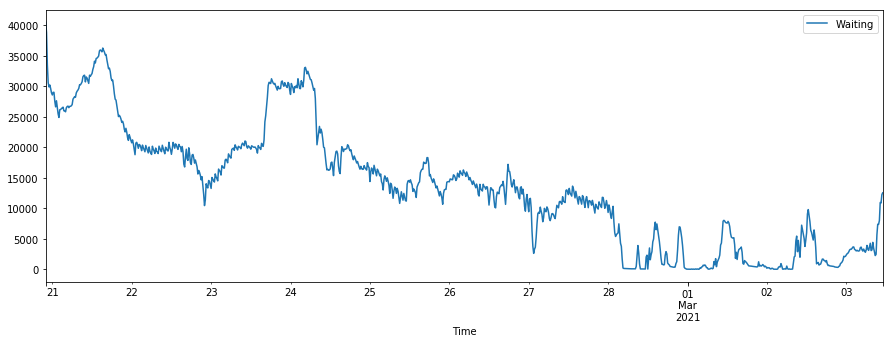

In [3]:
df.plot(figsize=(15, 5))

Unfortunately, we don't see regular patterns in this data. We can still try to decompose the time series into trend, seasonal and random (period 96 means we expect the seasonal period of 96 observations = 1 day):

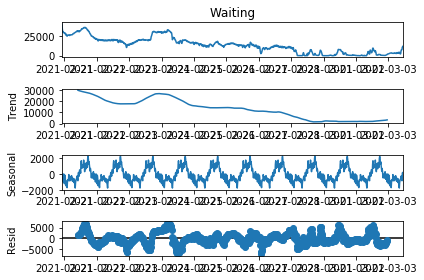

In [4]:
result = seasonal_decompose(df['Waiting'], model='additive', period=96)
result.plot()
plt.show()

We can see that the seasonal component is smaller than random (called residual here) (~2000 vs. ~5000).

## Forecasting

We can also try to forecast future observations based on historic ones. I will test several methods, from naive baselines, to proper forecasting models.

I am interested in forecasting the number of waiting submissions 1 hour in the future from the last known observation.

To test a forecasting algorithm, I will apply it to subsets of data and compare the forecasted value to the real one. More specifically, for i-th observation in the data (starting from i = 50), I will use observations 0-i to forecast the number of waiting submissions 1 hour into the future, that is observation i+4. This gives me ~960 forecasted values which I can then compare against real values. I will use MAE (mean absolute error) to have a feel how good (or bad) the forecasting approach is.

In [5]:
def predict(df, predict_fun):
    return [None] * 50 + [predict_fun(df, i) for i in range(50, len(df))]

def plot(df):
    df.plot(figsize=(15, 5))

def mae(df):
    errors = [abs(s) for s in list(df['Forecast']-df['Waiting'])[50:]]
    return sum(errors) / len(errors)

### Last known

This is a simple baseline. The forecast is last known observation, that is, the number of waiting submissions at time i+4 is forecasted as the number that was observed at time i.

1178.2419522326065


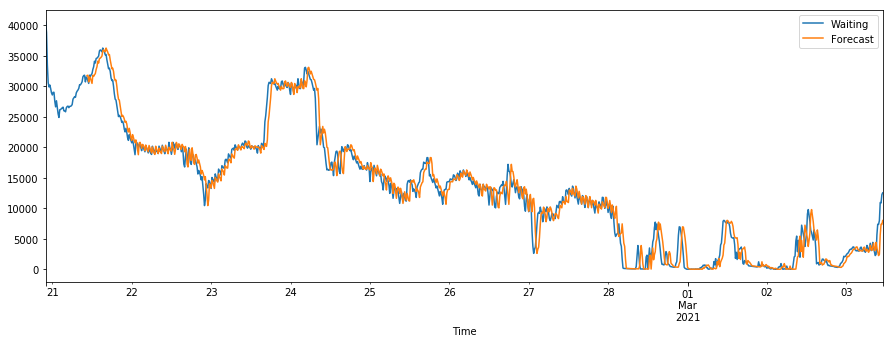

In [6]:
def predict_last(df, i):
    return list(df['Waiting'])[i-4]
    
df['Forecast'] = predict(df, predict_last)
mae_last_known = mae(df)
print(mae_last_known)
plot(df)

The plot shows the real values and forecasts. Unsurprisingly, forecasted values are simply real values shifted by one hour.

Mean absolute error is 1178, which means that on average, our forecast differs by 1178 from the real value.

### Hour average

This is another very simple method. The forecast is average number of observations from last hour.

In [7]:
def predict_hour_avg(df, i):
    return sum(list(df['Waiting'])[i-7:i-3]) / 4
    
df['Forecast'] = predict(df, predict_hour_avg)
mae_hour_avg = mae(df)
print(mae_hour_avg)
plot(df)

1360.5597092419523


The plot looks quite similar to the previous one, only smoother.

### 6 hours average

This is similar to the previous one, but observations from the last 6 hours are averaged.

In [8]:
def predict_6_hour_avg(df, i):
    return sum(list(df['Waiting'])[i-27:i-3]) / 24
    
df['Forecast'] = predict(df, predict_6_hour_avg)
mae_6_hour_avg = mae(df)
print(mae_6_hour_avg)
plot(df)

2285.8766441675357


As expected, the plot of forecasts is even smoother. The MAE is also much higher. It seems like the more past observations we include, the worse the forecast becomes.

### Autoregression

Here the forecast is a linear function of past observations.

1484.963736883764


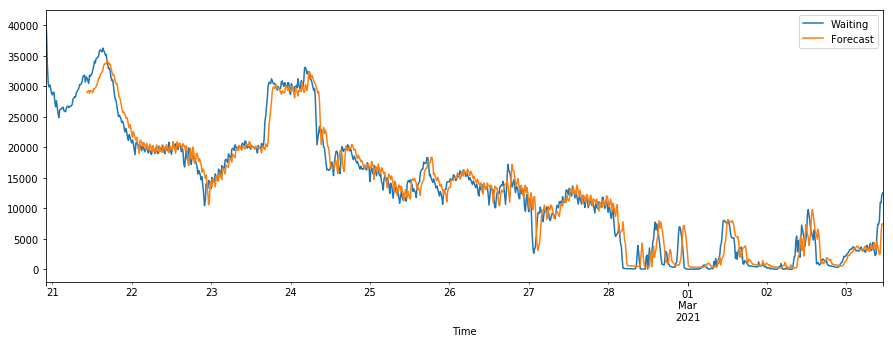

In [9]:
def predict_autoreg(df, i):
    train = df.iloc[:(i-4),:1]
    model = AutoReg(train, lags=1, old_names=False)
    model_fit = model.fit()
    return model_fit.forecast(steps=4)[3]
    
df['Forecast'] = predict(df, predict_autoreg)
mae_autoreg = mae(df)
print(mae_autoreg)
plot(df)

### ARIMA

Autoregressive Integrated Moving Average

1408.9449782558784


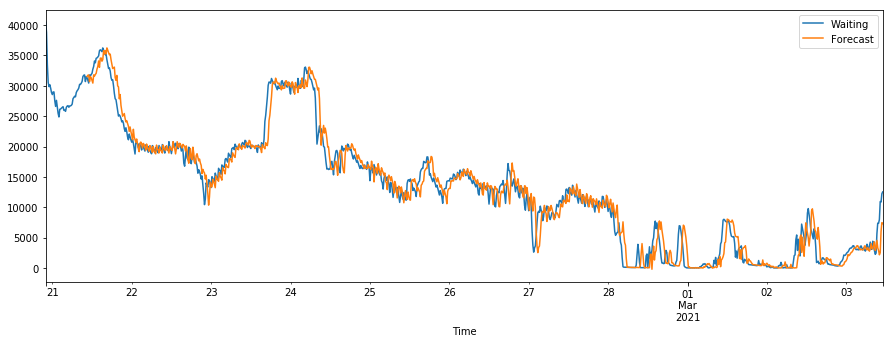

In [10]:
def predict_arima(df, i):
    train = df.iloc[:(i-4),:1]
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    return model_fit.forecast(steps=4)[3]
    
df['Forecast'] = predict(df, predict_arima)
mae_arima = mae(df)
print(mae_arima)
plot(df)

### Holt Winter’s Exponential Smoothing

In [11]:
def predict_hw(df, i):
    train = df.iloc[:(i-4),:1]
    model = ExponentialSmoothing(train)
    model_fit = model.fit()
    return model_fit.forecast(steps=4)[3]
    
df['Forecast'] = predict(df, predict_hw)
mae_hw = mae(df)
print(mae_hw)
plot(df)

1403.824336400438


### Holt Winter’s Exponential Smoothing with seasonality

1410.0971448388777


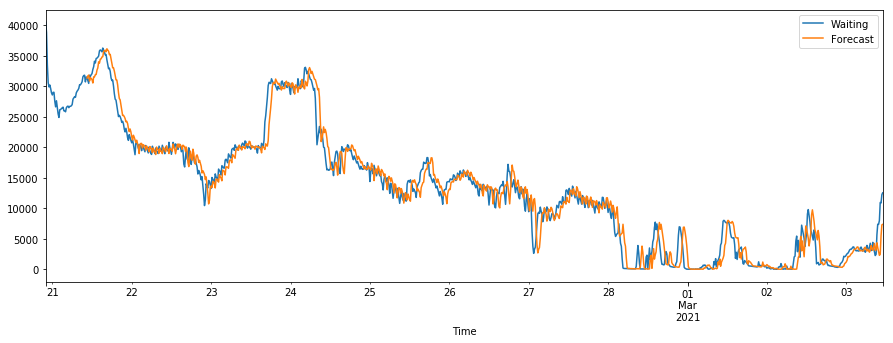

In [12]:
def predict_hw_seas(df, i):
    train = df.iloc[:(i-4),:1]
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=2)
    model_fit = model.fit()
    return model_fit.forecast(steps=4)[3]
    
df['Forecast'] = predict(df, predict_hw_seas)
mae_hw_seas = mae(df)
print(mae_hw_seas)
plot(df)

## Summary

Let's summarize MAE errors from different approaches:

In [13]:
maes = pd.DataFrame({'Method': ['Last known', 'Hour AVG', '6 hour AVG', 'Autoregression', 'ARIMA', 'Holt Winters',
                                'Holt Winters seasonal'],
                     'MAE':    [mae_last_known, mae_hour_avg, mae_6_hour_avg, mae_autoreg, mae_arima, mae_hw,
                                mae_hw_seas]},
                    columns = ['Method', 'MAE'])
maes.sort_values(by=['MAE'])

Method          MAE
0             Last known  1178.241952
1               Hour AVG  1360.559709
5           Holt Winters  1403.824336
4                  ARIMA  1408.944978
6  Holt Winters seasonal  1410.097145
3         Autoregression  1484.963737
2             6 hour AVG  2285.876644

Surprisingly, the simplest baseline approach outperforms more powerful techniques. This might be related to little seasonality and regularity in the data. Intuitively, if there are no patterns over time, the number of waiting submissions is mostly related to the closest values.

This is also confirmed by the shape of the plots. In most cases, the forecast plot shadows the real one shifted by 1 hour, meaning most methods forecast values close to the last observed one. This means past observation do not provide any information.

But why don't we observe seasonality? It is possible that the period is in fact longer that the data we collected so far, for example 1 week. In that case we don't have enough data to see the patterns yet.

There were also multiple interventions in the queue processing last week, and this dataset might be simply a very unusual sample.